# TlF beam velocity characterization

In this notebook I'm going to simulate the velocity distributions expected to be seen in the laser induced fluorescence characterization of the CeNTREX cryogenic buffer gas beam source. The idea is to calculate the trajectories of molecules from the source to the point where the laser intersects the molecule beam in order to get the velocity distributions of the molecules that we will observe. This can then be compared to the experimental data to test how well our beamline simulations can be expected to work. A diagram of the experimental setup is shown below.
<img src="./Diagrams/Basic setup.svg" />

First we'll import some necessary modules.

In [1]:
from functions import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#%%Start clock
start  = time.time()

Define the dimensions of the vacuum apparatus (beamsource, ISO100 to KF50 and octagonal vacuum chamber).

In [2]:
#Beamline parameters (i.e. positions and dimensions of apertures, lenses etc.) (all in meters):
#Measuring z-positions relative to cell aperture

meters_per_inch = 0.0254 #conversion factor from inches to meters

#Cell aperture and zone of freezing dimensions (zone of freezing is the
#region where the molecules "spawn")
cell_aperture = {}
cell_aperture['d'] = meters_per_inch*0.25   #Cell aperture diameter
cell_aperture['z'] = 0

zone_of_freezing = {}                      #Cell aperture position z
zone_of_freezing['z'] = 1*cell_aperture['d']   #position of zone of freezing
zone_of_freezing['d'] = .02                #diameter of zone of freezing

#4K collimator dimensions (cone)
FourK_collimator = {}
FourK_collimator['z_1'] = 0.325*meters_per_inch #4K collimator start z position
FourK_collimator['d_1'] = 0.232*meters_per_inch #4K collimator start diameter
FourK_collimator['z_2'] = FourK_collimator['z_1'] + 1*meters_per_inch #4K collimator end z position
FourK_collimator['d_2'] = 1*meters_per_inch #4K collimator end diameter
FourK_collimator['type'] = 'circle' #Specify cross section type
FourK_collimator['name'] = 'FourK_collimator'

#4K shield dimensions
FourK_shield = {}
FourK_shield['z_1'] = FourK_collimator['z_2']+ meters_per_inch * 0.375 #4K shield z position
FourK_shield['z_2'] = FourK_shield['z_1'] + meters_per_inch * 0.25 #4K shield z position
FourK_shield['d_1'] = meters_per_inch*1 #4K shield aperture diameter
FourK_shield['d_2'] = meters_per_inch*1 #4K shield aperture diameter
FourK_shield['type'] = 'circle' #Specify cross section type
FourK_shield['name'] = 'FourK_shield'

#40K shield dimensions
FortyK_shield = {}
FortyK_shield['z_1'] = FourK_shield['z_2'] + meters_per_inch * 1.25 #40K shield z position
FortyK_shield['z_2'] = FortyK_shield['z_1'] + meters_per_inch * .25 #40K shield z position
FortyK_shield['d_1'] = meters_per_inch*1 #40K shield aperture diameter
FortyK_shield['d_2'] = meters_per_inch*1 #40K shield aperture diameter
FortyK_shield['type'] = 'circle' #Specify cross section type
FortyK_shield['name'] = 'FortyK_shield'


#Beam box exit dimensions
BB_exit = {}
BB_exit['z_1'] = FortyK_shield['z_2'] + meters_per_inch * 2.5 #z position
BB_exit['z_2'] = BB_exit['z_1'] + meters_per_inch * 0.75 #z position
BB_exit['d_1'] = meters_per_inch*4 #diameter of beam box exit
BB_exit['d_2'] = BB_exit['d_1'] #diameter of beam box exit
BB_exit['type'] = 'circle' #Specify cross section type
BB_exit['name'] = 'BB_exit'

#ISO100 to KF 50 reducer
ISO100_to_KF50 = {}
ISO100_to_KF50['z_1'] = BB_exit['z_2'] #Reducer is directly attached to beamsource
ISO100_to_KF50['z_2'] = ISO100_to_KF50['z_1'] + meters_per_inch*1.48
ISO100_to_KF50['d_1'] = 1.84*meters_per_inch
ISO100_to_KF50['d_2'] = ISO100_to_KF50['d_1']
ISO100_to_KF50['type'] = 'circle'
ISO100_to_KF50['name'] = 'ISO100_to_KF50'

#Octagon chamber entrance
OC_entrance = {}
OC_entrance['z_1'] = ISO100_to_KF50['z_2']
OC_entrance['z_2'] = OC_entrance['z_1']  + meters_per_inch*1.344
OC_entrance['d_1'] = meters_per_inch*1.95 #inner diameter of KF50 o-ring
OC_entrance['d_2'] = OC_entrance['d_1']
OC_entrance['type'] = 'circle'
OC_entrance['name'] = 'OC_entrance'

#Fluorescence region
#Taking the fluorescence region to be a line through the center of the octagonal chamber perpendicular to the molecular beam
#even though for the longitudinal velocity the laser is actually at 45 degrees
Fluorescence_region = {}
Fluorescence_region['z_1'] = OC_entrance['z_2'] + meters_per_inch*3.5
Fluorescence_region['z_2'] = Fluorescence_region['z_1']
Fluorescence_region['w'] = meters_per_inch*7
Fluorescence_region['h'] = 0.02 #assuming laser diameter of 2 cm
Fluorescence_region['x_1'] = -Fluorescence_region['w']/2
Fluorescence_region['x_2'] =  Fluorescence_region['w']/2
Fluorescence_region['y_1'] = -Fluorescence_region['h']/2
Fluorescence_region['y_2'] = Fluorescence_region['h']/2
Fluorescence_region['type'] = 'square'
Fluorescence_region['name'] = 'Fluorescence_region'

#Next we put all of the previously defined structures into another structure called beamline geometry. Make
#sure to enter the beamline elements in the correct order (i.e. 1st element along beamline corresponds to 1st index)
beamline_geometry = {}
beamline_geometry[1] = FourK_collimator
beamline_geometry[2] = FourK_shield
beamline_geometry[3] = FortyK_shield
beamline_geometry[4] = BB_exit
beamline_geometry[5] = ISO100_to_KF50
beamline_geometry[6] = OC_entrance
beamline_geometry[7] = Fluorescence_region

In [3]:
#Next we define the beam properties. The velocities in the beam are assumed 
#to be described by Gaussians with mean of 200 m/s and std.dev. of 13 m/s for 
#the longitudinal velocity, and  with  for the transverse direction. The intial
#spatial distribution of the beam is taken to be a 1cm diameter circle filled 
#uniformly:
beam = {}
beam['v_z'] = 200 #longitudinal velocity (m/s)
beam['sigma_v_z'] = 13 #spread in longitudinal velocity (m/s)
beam['v_t'] = 0 #transverse velocities should be zero on average but with some spread
beam['sigma_v_x'] = 57 #spread in x velocity (m/s)
beam['sigma_v_y'] = beam['sigma_v_x']; #spread in y velocity (m/s)
beam['d'] = 0.01; #initial diameter of beam

In [4]:
#%% Next we specify the properties of the molecule in question (TlF, need to 
# specify J value)

#Molecule parameters
molecule = {}
molecule['m'] = (204.38+19.00)*1.67e-27 #TlF molecular mass in kg
molecule['J'] = 2 #Rotational quantum number of molecule (m_J = 0 by assumption)

In [62]:
# Now we can run the simulation of the trajectories:
N_molecules = 1e7; #Set number of trajectories to calculate

#Start clock and then call the function that is used to calculate the trajectories
store_trajectories = True;

#Start clock
start  = time.time()

#Call the function that simulates the trajectories
trajectories, velocities, counts = trajectories_function(zone_of_freezing,beamline_geometry,beam,molecule,
                                                                 N_molecules,store_trajectories);

#%% Stop clock and print out time elapsed
end = time.time()
time_elapsed = end - start
print("Time elapsed = %s" % time_elapsed)




Time elapsed = 108.95110082626343


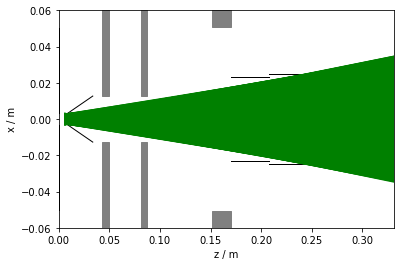

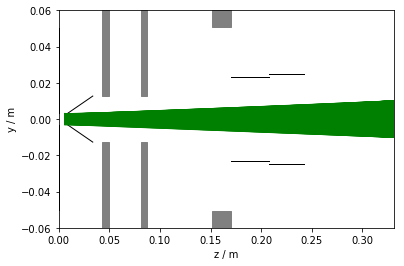

In [6]:
#%%Next we plot the trajectories if number of molecules is small enough
if N_molecules <= 1e6:
    fig1, ax1 = plt.subplots(1)
    #Plot the cell aperture
    plt.plot([0, 0],[cell_aperture['d']/2, 0.05],'k',linewidth = 1)
    plt.plot([0, 0],[-cell_aperture['d']/2, -0.05],'k',linewidth = 1)
    
    #Plot 4K Collimator
    plt.plot([FourK_collimator['z_1'], FourK_collimator['z_2']],[FourK_collimator['d_1']/2, FourK_collimator['d_2']/2],'k',linewidth=1)
    plt.plot([FourK_collimator['z_1'], FourK_collimator['z_2']],[-FourK_collimator['d_1']/2, -FourK_collimator['d_2']/2],'k',linewidth=1)
    
    #Plot 4K shield
    rect1 = patches.Rectangle((FourK_shield['z_1'], FourK_shield['d_1']/2), FourK_shield['z_2']-FourK_shield['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((FourK_shield['z_1'], -FourK_shield['d_1']/2-1), FourK_shield['z_2']-FourK_shield['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    
    #Plot 40K shield
    rect1 = patches.Rectangle((FortyK_shield['z_1'], FortyK_shield['d_1']/2), FortyK_shield['z_2']-FortyK_shield['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((FortyK_shield['z_1'], -FortyK_shield['d_1']/2-1), FortyK_shield['z_2']-FortyK_shield['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    
    #Plot Beambox exit shield
    rect1 = patches.Rectangle((BB_exit['z_1'], BB_exit['d_1']/2), BB_exit['z_2']-BB_exit['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((BB_exit['z_1'], -BB_exit['d_1']/2-1), BB_exit['z_2']-BB_exit['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    
    #Plot ISO100 to KF50 reducer
    plt.plot([ISO100_to_KF50['z_1'], ISO100_to_KF50['z_2']],[ISO100_to_KF50['d_1']/2, ISO100_to_KF50['d_2']/2],'k',linewidth=1)
    plt.plot([ISO100_to_KF50['z_1'], ISO100_to_KF50['z_2']],[-ISO100_to_KF50['d_1']/2, -ISO100_to_KF50['d_2']/2],'k',linewidth=1)
    
    #Plot octagon chamber entrance
    plt.plot([OC_entrance['z_1'], OC_entrance['z_2']],[OC_entrance['d_1']/2, OC_entrance['d_2']/2],'k',linewidth=1)
    plt.plot([OC_entrance['z_1'], OC_entrance['z_2']],[-OC_entrance['d_1']/2, -OC_entrance['d_2']/2],'k',linewidth=1)
    
    #Plot Fluorescence region entrance
    rect1 = patches.Rectangle((Fluorescence_region['z_1'], Fluorescence_region['x_2']), 0.02, 0.02, color = 'k')
    rect2 = patches.Rectangle((Fluorescence_region['z_1'], Fluorescence_region['x_1']-0.02), 0.02, 0.02,color = 'k')
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    
    #Set axes etc
    plt.ylim([-0.06, 0.06])
    #plt.xlim([0, 0.3])
    plt.xlim([0, Fluorescence_region['z_2']])
    
    plt.xlabel('z / m')
    plt.ylabel('x / m')
    
    #Now plot the trajectories
    for trajectory in trajectories['detected']:
        plt.plot(trajectory[2,:],trajectory[0,:],'g')
        
    
    
    plt.show()
    
    #Next plot the trajectories in yz-plane
    fig2, ax2 = plt.subplots()
    #Plot the cell aperture
    plt.plot([0, 0],[cell_aperture['d']/2, 0.05],'k',linewidth = 1)
    plt.plot([0, 0],[-cell_aperture['d']/2, -0.05],'k',linewidth = 1)
    
    #Plot 4K Collimator
    plt.plot([FourK_collimator['z_1'], FourK_collimator['z_2']],[FourK_collimator['d_1']/2, FourK_collimator['d_2']/2],'k',linewidth=1)
    plt.plot([FourK_collimator['z_1'], FourK_collimator['z_2']],[-FourK_collimator['d_1']/2, -FourK_collimator['d_2']/2],'k',linewidth=1)
    
    #Plot 4K shield
    rect1 = patches.Rectangle((FourK_shield['z_1'], FourK_shield['d_1']/2), FourK_shield['z_2']-FourK_shield['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((FourK_shield['z_1'], -FourK_shield['d_1']/2-1), FourK_shield['z_2']-FourK_shield['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)
    
    #Plot 40K shield
    rect1 = patches.Rectangle((FortyK_shield['z_1'], FortyK_shield['d_1']/2), FortyK_shield['z_2']-FortyK_shield['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((FortyK_shield['z_1'], -FortyK_shield['d_1']/2-1), FortyK_shield['z_2']-FortyK_shield['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)
    
    
    #Plot Beambox exit shield
    rect1 = patches.Rectangle((BB_exit['z_1'], BB_exit['d_1']/2), BB_exit['z_2']-BB_exit['z_1'], 1, color = (.5, .5,.5))
    rect2 = patches.Rectangle((BB_exit['z_1'], -BB_exit['d_1']/2-1), BB_exit['z_2']-BB_exit['z_1'], 1,color = (0.5, 0.5, 0.5))
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)
    
    #Plot ISO100 to KF50 reducer
    plt.plot([ISO100_to_KF50['z_1'], ISO100_to_KF50['z_2']],[ISO100_to_KF50['d_1']/2, ISO100_to_KF50['d_2']/2],'k',linewidth=1)
    plt.plot([ISO100_to_KF50['z_1'], ISO100_to_KF50['z_2']],[-ISO100_to_KF50['d_1']/2, -ISO100_to_KF50['d_2']/2],'k',linewidth=1)
    
    #Plot octagon chamber entrance
    plt.plot([OC_entrance['z_1'], OC_entrance['z_2']],[OC_entrance['d_1']/2, OC_entrance['d_2']/2],'k',linewidth=1)
    plt.plot([OC_entrance['z_1'], OC_entrance['z_2']],[-OC_entrance['d_1']/2, -OC_entrance['d_2']/2],'k',linewidth=1)
    
    #Plot Fluorescence region entrance
    rect1 = patches.Rectangle((Fluorescence_region['z_1'], Fluorescence_region['y_2']), 0.02, 0.02, color = 'k')
    rect2 = patches.Rectangle((Fluorescence_region['z_1'], Fluorescence_region['y_1']-0.02), 0.02, 0.02,color = 'k')
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)
    
    #Set axes etc
    plt.ylim([-0.06, 0.06])
    #plt.xlim([0, 0.3])
    plt.xlim([0, Fluorescence_region['z_2']])
    
    plt.xlabel('z / m')
    plt.ylabel('y / m')
    
    
    #Plot trajectories       
    for trajectory in trajectories['detected']:
        plt.plot(trajectory[2,:],trajectory[1,:],'g')
        
        
    plt.show()
    

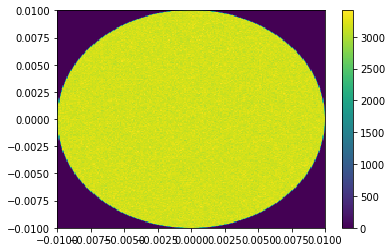

In [7]:
#Also plot the initial distribution in positions as a check
#Note: this is not the actual initial distribution used above, just another
#set of numbers generated from the same pdfs
size = int(1e8)
theta = np.random.rand(1,size)*2*np.pi
r = (np.sqrt(np.random.rand(1,size)) 
    * zone_of_freezing['d']/2)

x_ini = np.zeros((size,3))
#Store the initial positions in an array. Each new row of the array
#corresponds to a new molecule. Starting z-position is set later.
x_ini[:,0] = r*np.cos(theta)
x_ini[:,1] = r*np.sin(theta)

plt.figure()
plt.hist2d(x_ini[:,0],x_ini[:,1], bins = 200);
plt.colorbar()
plt.show()



Plot the velocity spread in the x-direction as a histogram

Text(0,0.5,'Number of counts')

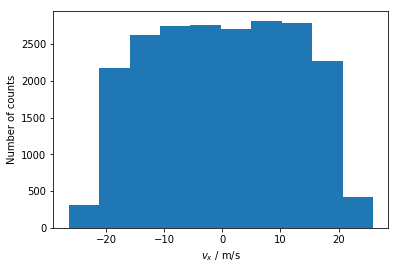

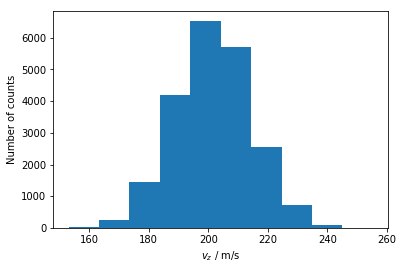

In [64]:
v_x = []
v_z = []
for v in velocities['detected']:
    v_x.append(v[0,-1])
    v_z.append(v[2,-1])

fig1, ax1 = plt.subplots()    
plt.hist(v_x)
plt.xlabel('$v_x$ / m/s')
plt.ylabel('Number of counts')

fig2, ax2 = plt.subplots()
plt.hist(v_z)
plt.xlabel('$v_z$ / m/s')
plt.ylabel('Number of counts')

Thus for the x direction we can expect a cutoff Gaussian with a spread of ~ 20 m/s and for the z-direction just a regular gaussian. The fact that particles with higher x-velocity will be further away from the lightpipe means that the signal from the would be reduced which should modulate the distribution.